# Corona prepping using Finnish data EDA

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix,
                     summary_performance_metrics_classification)

# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit
# from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn.model_selection import KFold

In [5]:
# from sklearn import tree
# import graphviz

In [6]:
from catboost import CatBoostClassifier, Pool

In [7]:
# import xgboost
import shap
shap.initjs()

In [8]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [9]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [10]:
# df = pd.read_csv("data/shield_gjames_21-06-10.csv").drop("id", axis=1)
df = pd.read_csv("data/shield_gjames_21-07-25.csv")

In [11]:
variables_df = pd.read_csv("data/Citizen Shield notes - Variable names.csv", sep=";")

In [12]:
variables_df["Type"].unique()

array(['demographic', 'behaviour', 'mask_wearing', 'intention',
       'automaticity', 'post_covid_maskwearing', 'instrumental_attitude',
       'norms', 'affective_attitude', 'barriers', 'effective_means',
       'perceived_risk', 'sdt_needs', 'sdt_motivation', 'attention_check',
       'vaccination_status', 'needprotection', 'children_age_groups'],
      dtype=object)

In [13]:
target_list = ["behaviour_unmasked", "intention_indoor_meeting"]

In [14]:
variable_types_list = [
    # "demographic",
  # "behaviour",
  # "mask_wearing",
  # "intention",
  "automaticity",
  # "post_covid_maskwearing",
  "instrumental_attitude",
  "norms",
  "affective_attitude",
  # "barriers",
  # "effective_means",
  "perceived_risk"
  # "sdt_needs",
  # "sdt_motivation"
  # "attention_check",
  # "vaccination_status",
  # "needprotection"
  # "children_age_groups"
]

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [15]:
variables_list = ["demographic_age", "sampling_weight"] + target_list + variables_df.loc[variables_df["Type"].isin(variable_types_list), "New variable name"].values.tolist()
features_list = ["demographic_age"] + variables_df.loc[variables_df["Type"].isin(variable_types_list), "New variable name"].values.tolist()
features_list

['demographic_age',
 'automaticity_carry_mask',
 'automaticity_put_on_mask',
 'inst_attitude_protects_self',
 'inst_attitude_protects_others',
 'inst_attitude_sense_of_community',
 'inst_attitude_enough_oxygen',
 'inst_attitude_no_needless_waste',
 'norms_family_friends',
 'norms_risk_groups',
 'norms_officials',
 'norms_people_present_indoors',
 'aff_attitude_comfortable',
 'aff_attitude_calm',
 'aff_attitude_safe',
 'aff_attitude_responsible',
 'aff_attitude_difficult_breathing',
 'risk_likely_contagion',
 'risk_contagion_absent_protection',
 'risk_severity',
 'risk_fear_spread',
 'risk_fear_contagion_self',
 'risk_fear_contagion_others',
 'risk_fear_restrictions']

In [16]:
df = (df
 .loc[:, variables_list]
 .assign(target = ((df[target_list[0]] == 5).astype(int).add((df[target_list[1]] != 3).astype(int)) == 2).astype(int))
      .drop(target_list, axis=1)
)

In [17]:
grouping_var = "target"

In [18]:
df.head()

demographic_age  sampling_weight  automaticity_carry_mask  \
0           18-29         2.009690                        6   
1             60+         2.130066                        6   
2             60+         1.919822                        6   
3           18-29         1.167936                        1   
4           18-29         1.438140                        5   

   automaticity_put_on_mask  inst_attitude_protects_self  \
0                         6                            4   
1                         6                            7   
2                         7                            6   
3                         1                            4   
4                         3                            7   

   inst_attitude_protects_others  inst_attitude_sense_of_community  \
0                              7                                 6   
1                              7                                 6   
2                              6                                 6   
3                              7                                 1   
4                              7                                 7   

   inst_attitude_enough_oxygen  inst_attitude_no_needless_waste  \
0                            5                                4   
1                            5                                4   
2                            4                                4   
3                            2                                2   
4                            5                                1   

   norms_family_friends  ...  aff_attitude_responsible  \
0                     5  ...                         6   
1                     7  ...                         7   
2                     7  ...                         6   
3                     4  ...                         7   
4                     7  ...                         7   

   aff_attitude_difficult_breathing  risk_likely_contagion  \
0                                 4                      3   
1                                 5                      2   
2                                 3                      2   
3                                 5                      2   
4                                 2                      4   

   risk_contagion_absent_protection  risk_severity  risk_fear_spread  \
0                                 5              5                 6   
1                                 4              6                 7   
2                                 4              6                 5   
3                                 2              7                 5   
4                                 6              3                 7   

   risk_fear_contagion_self  risk_fear_contagion_others  \
0                         6                           6   
1                         6                           7   
2                         6                           7   
3                         6                           7   
4                         7                           7   

   risk_fear_restrictions  target  
0                       3       1  
1                       2       0  
2                       1       1  
3                       1       0  
4                       1       0  

[5 rows x 26 columns]

In [19]:
# sdt_columns = df.filter(regex="sdt").columns.tolist()

# drop_sdt = True
# if drop_sdt:
#     df=df.drop(sdt_columns, axis=1)

# df.shape

## Force all variables to categorical data

In [20]:
df[features_list] = df[features_list].astype("category")
# df["sampling_weight"] = df["sampling_weight"].astype(float)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   category
 1   sampling_weight                   2272 non-null   float64 
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

## EDA on the target
Check the amount of samples in the target

In [22]:
print(df[grouping_var].value_counts())

0    1545
1     727
Name: target, dtype: int64


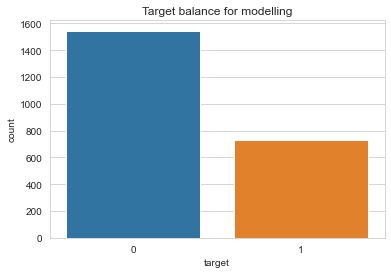

In [23]:
_ = sns.countplot(x=df[grouping_var])
_ = plt.title("Target balance for modelling")
_ = plt.show()

In [24]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  sample_weights: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(30,10))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
#                     palette="Set2"
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostClassifier(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='Logloss',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list, sample_weight=sample_weights)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 20))
    gini_plot = sns.barplot(data=feature_importance_df#[feature_importance_df["feature_importance"] != 0]
                            , 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    # model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = shap_values[:,:-1]

#     _ = plt.figure(figsize=(7, 10))
    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    # model = CatBoostClassifier(iterations=500,
    #                            depth=None,
    #                            learning_rate=1,
    #                            loss_function='Logloss',
    #                            verbose=False)

    # train the model
    _ = model.fit(X[feature_importance_df.head(2).feature.tolist()], y, cat_features=feature_importance_df.head(2).feature.tolist())

    dec_bound_plot = plot_decision_boundary(X=X[feature_importance_df.head(2).feature.tolist()], 
                               y=y, clf=model, 
                               title = f'CatBoost Decision Boundary {plot_title}', 
                               legend_title = "Mask Use")
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), dec_bound_plot, feature_importance_df, shap_actual_df

In [25]:
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = features_list[2:],
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

In [26]:
# feature_plot_0

In [27]:
# features_list[2:]

In [28]:
# df.filter(regex="sdt").columns.tolist()

In [29]:
# %%capture
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

# feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="40 - 59"
#                                                                                   )

# feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="60+"
#                                                                                   )

# feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="All"
#                                                                                   )

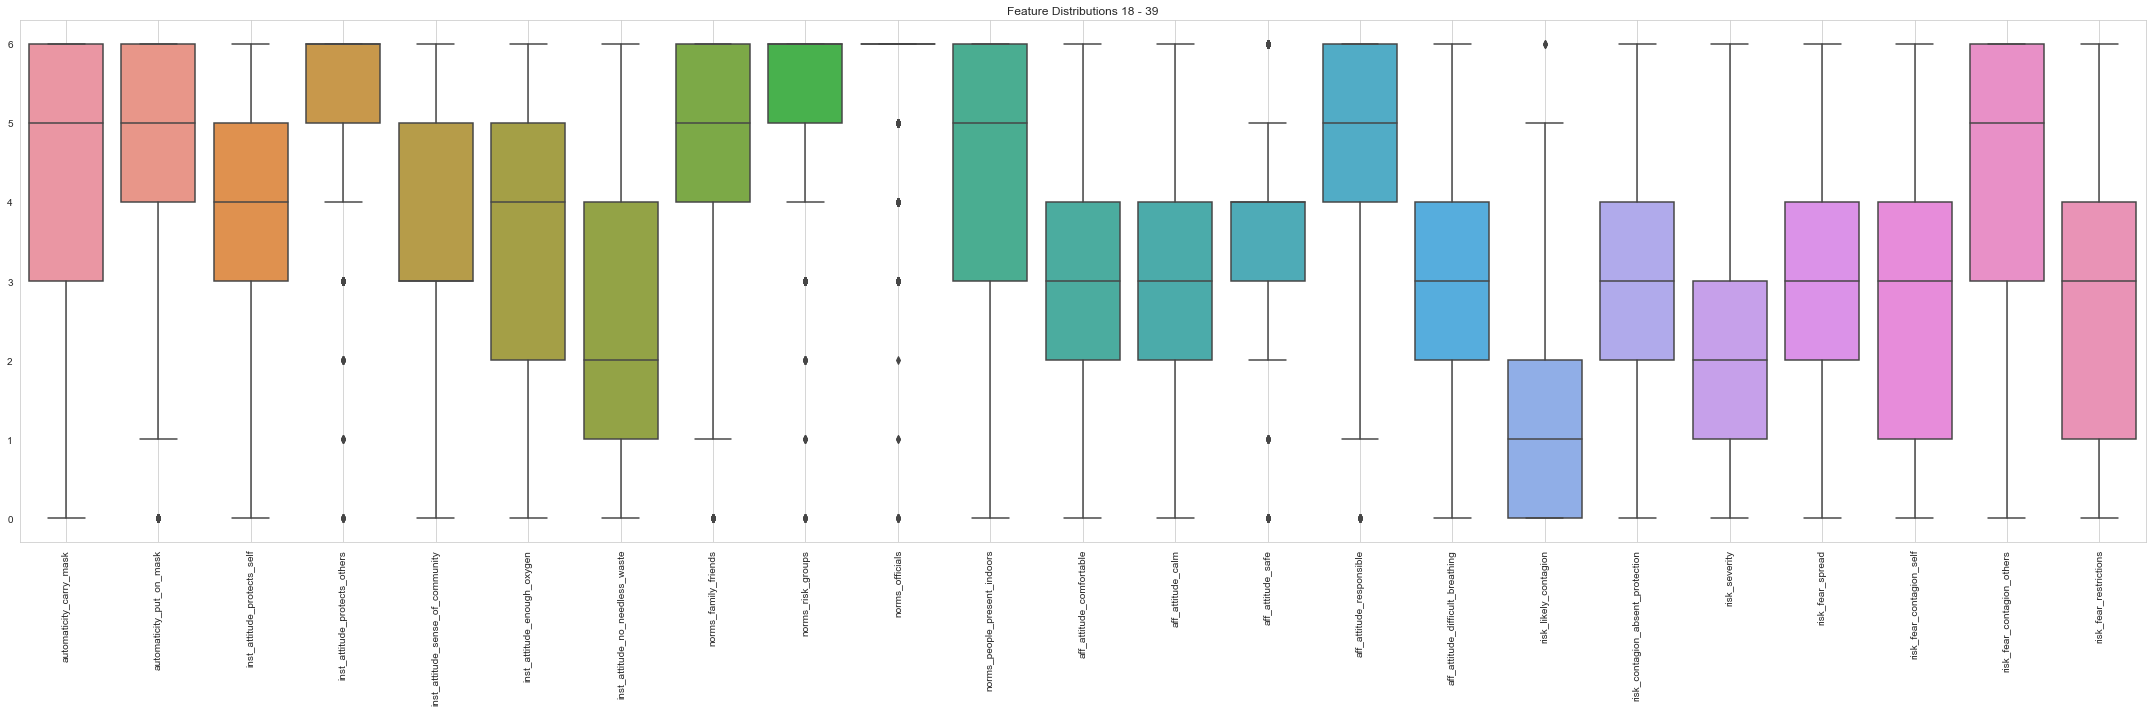

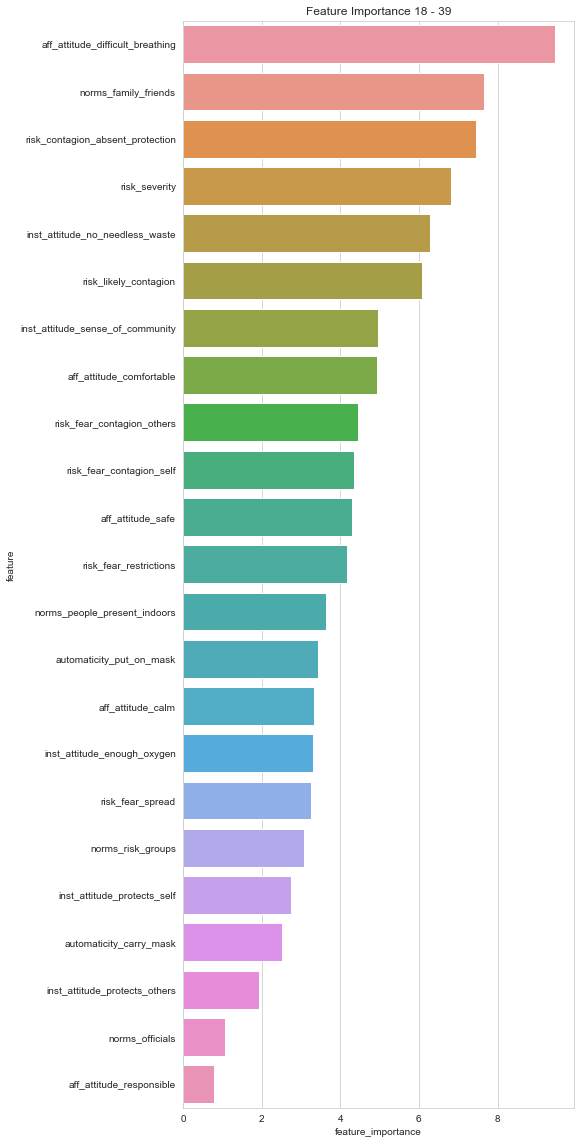

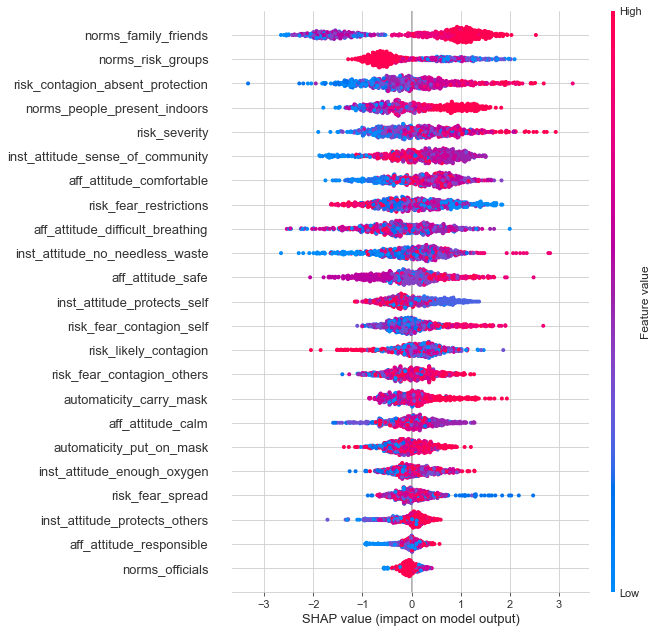

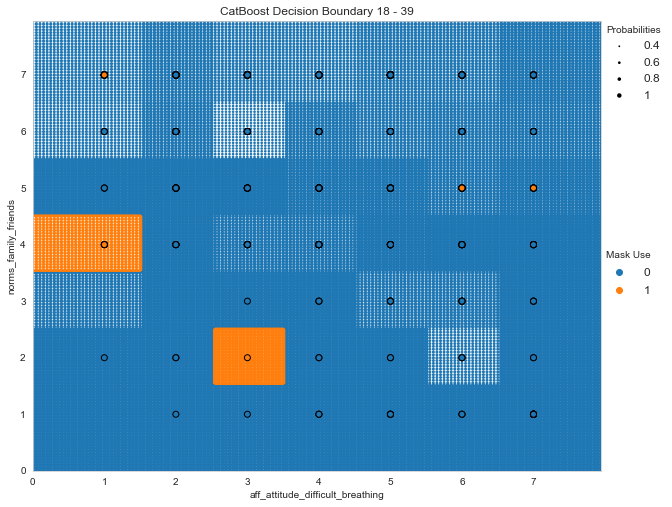

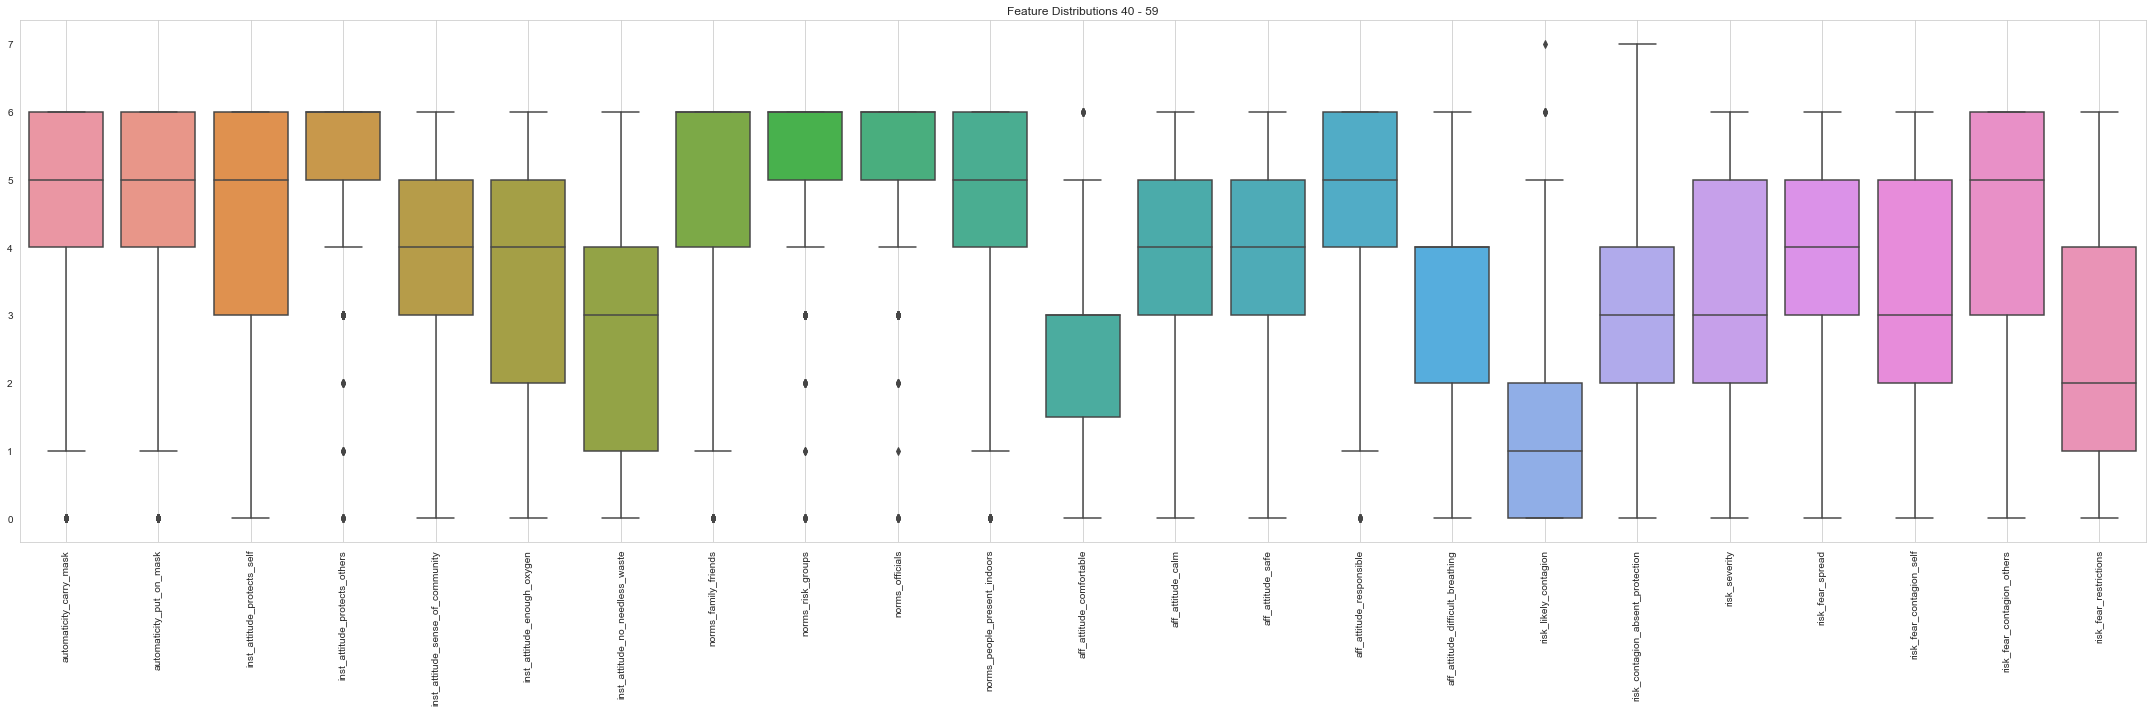

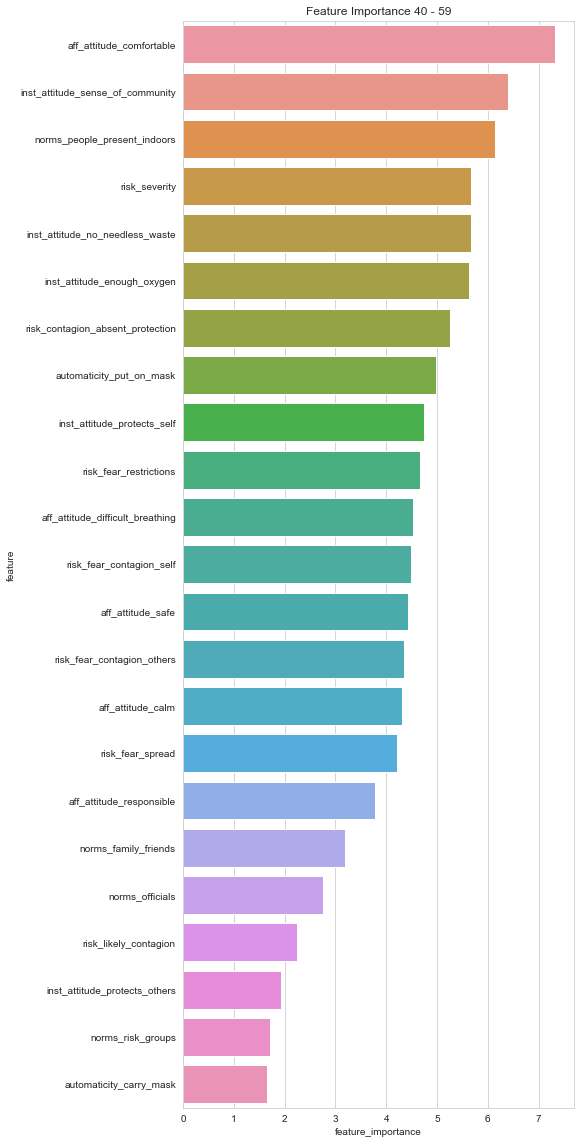

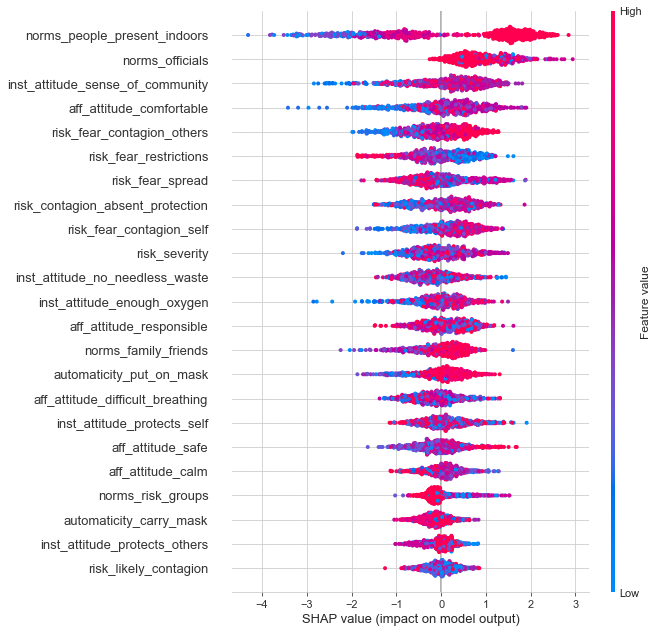

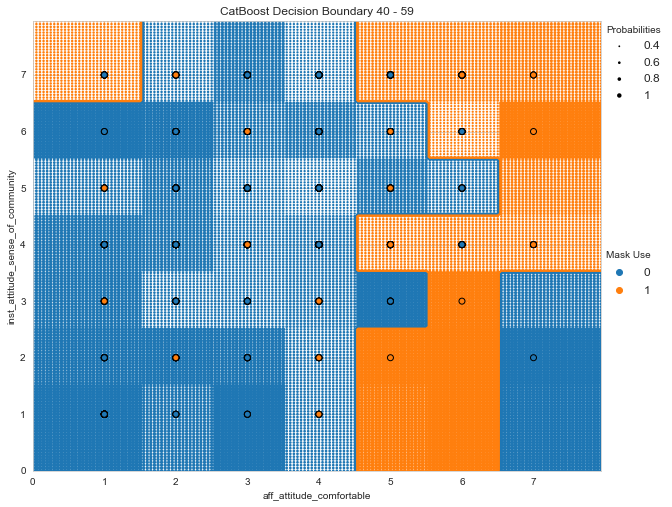

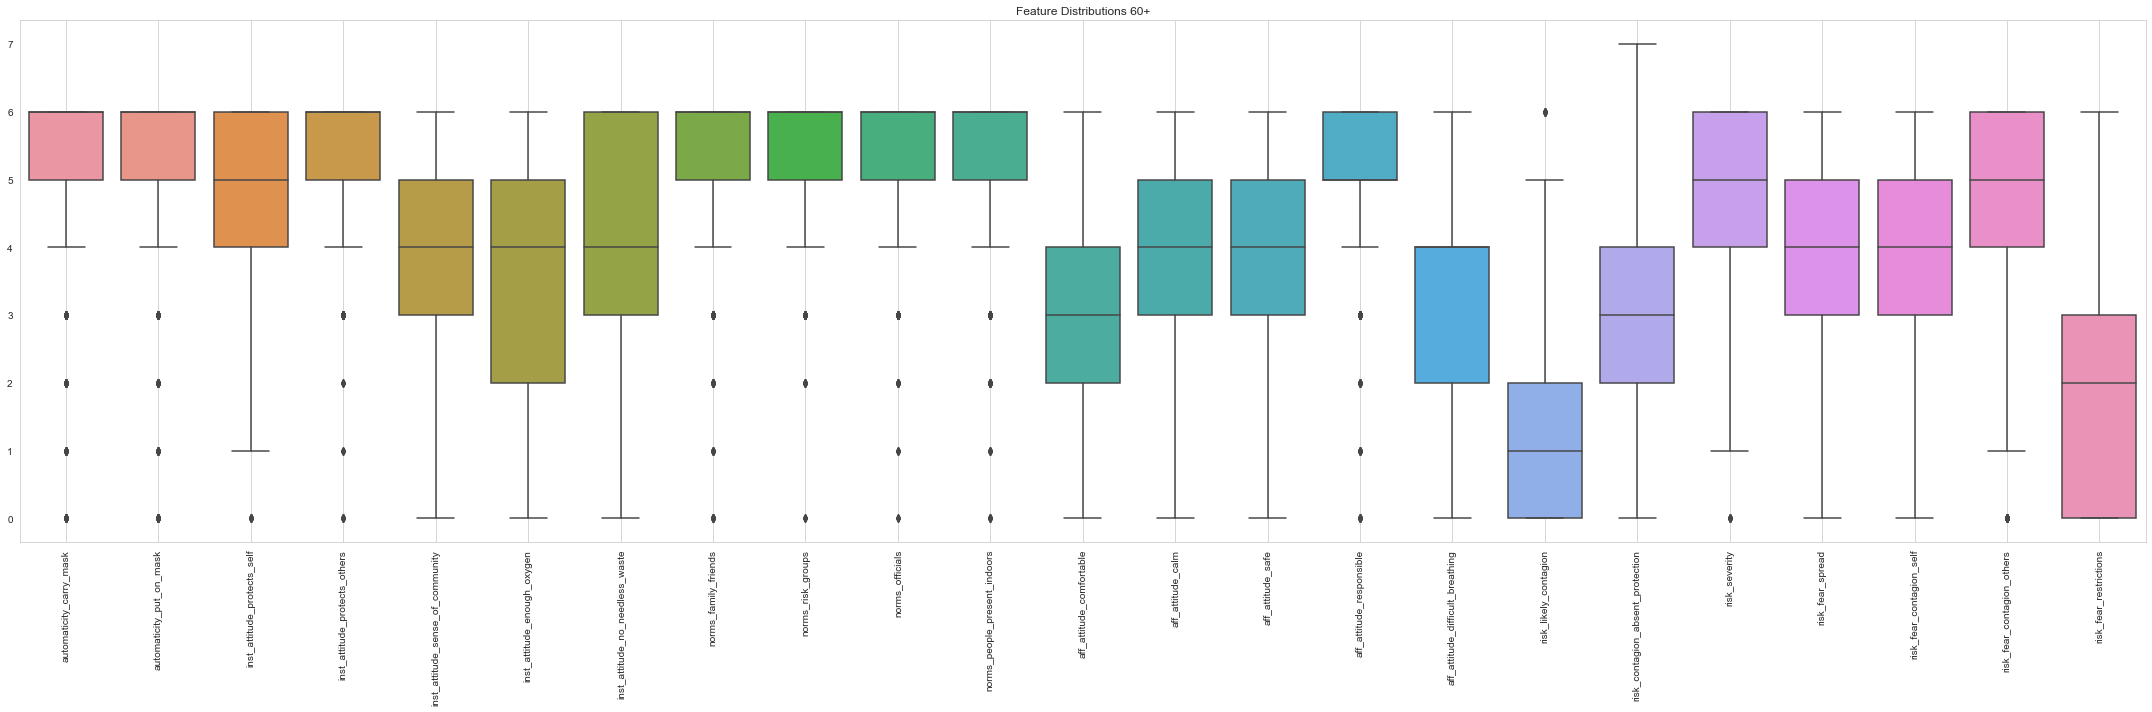

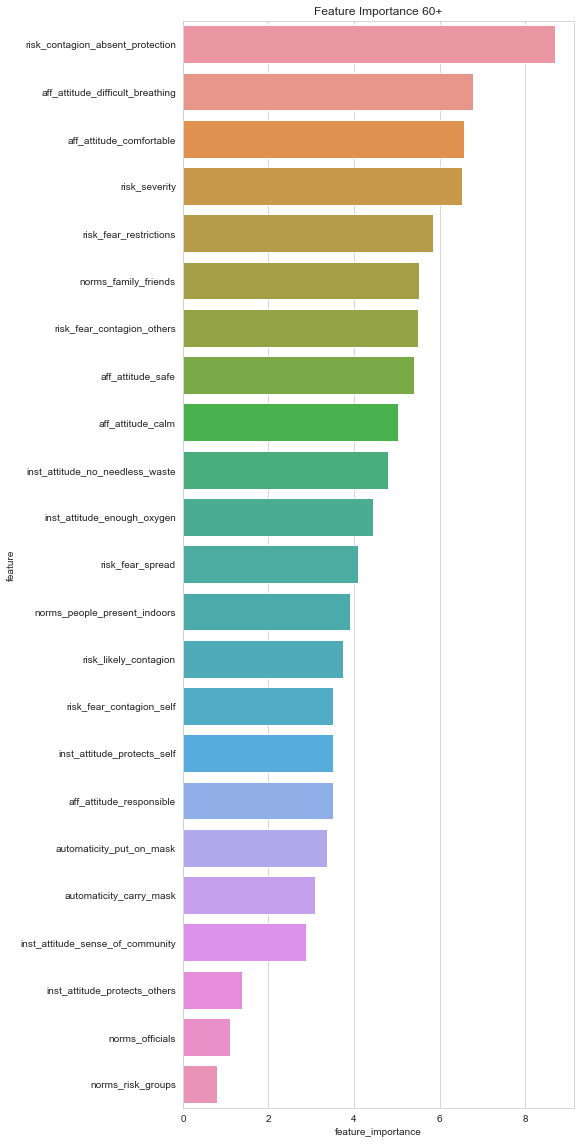

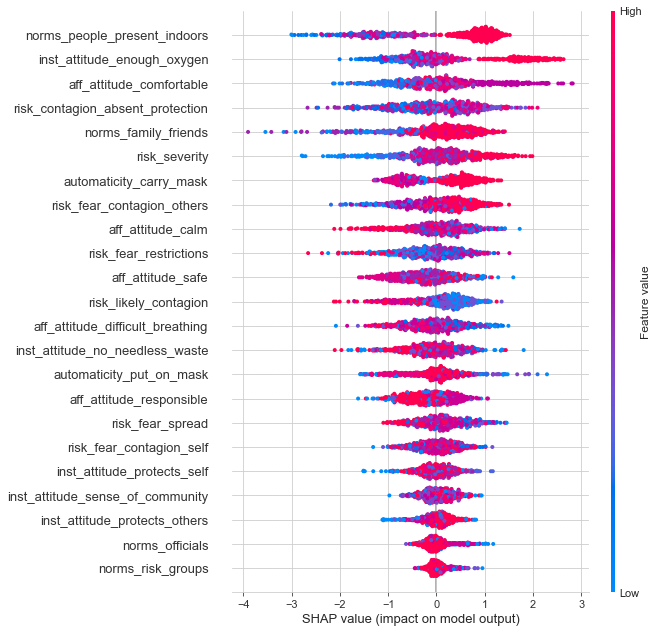

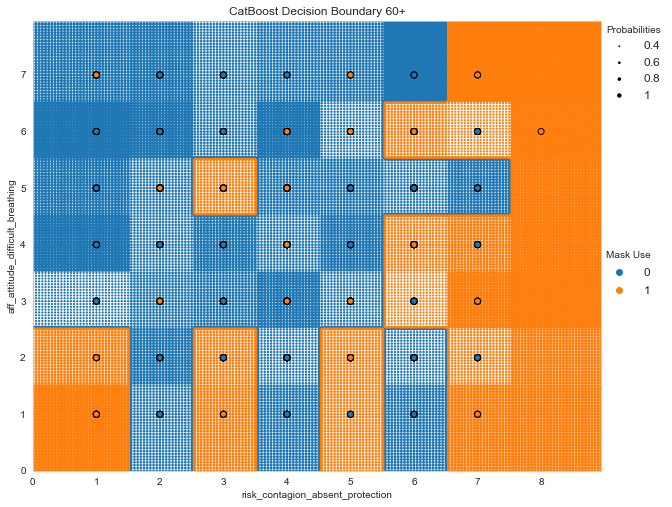

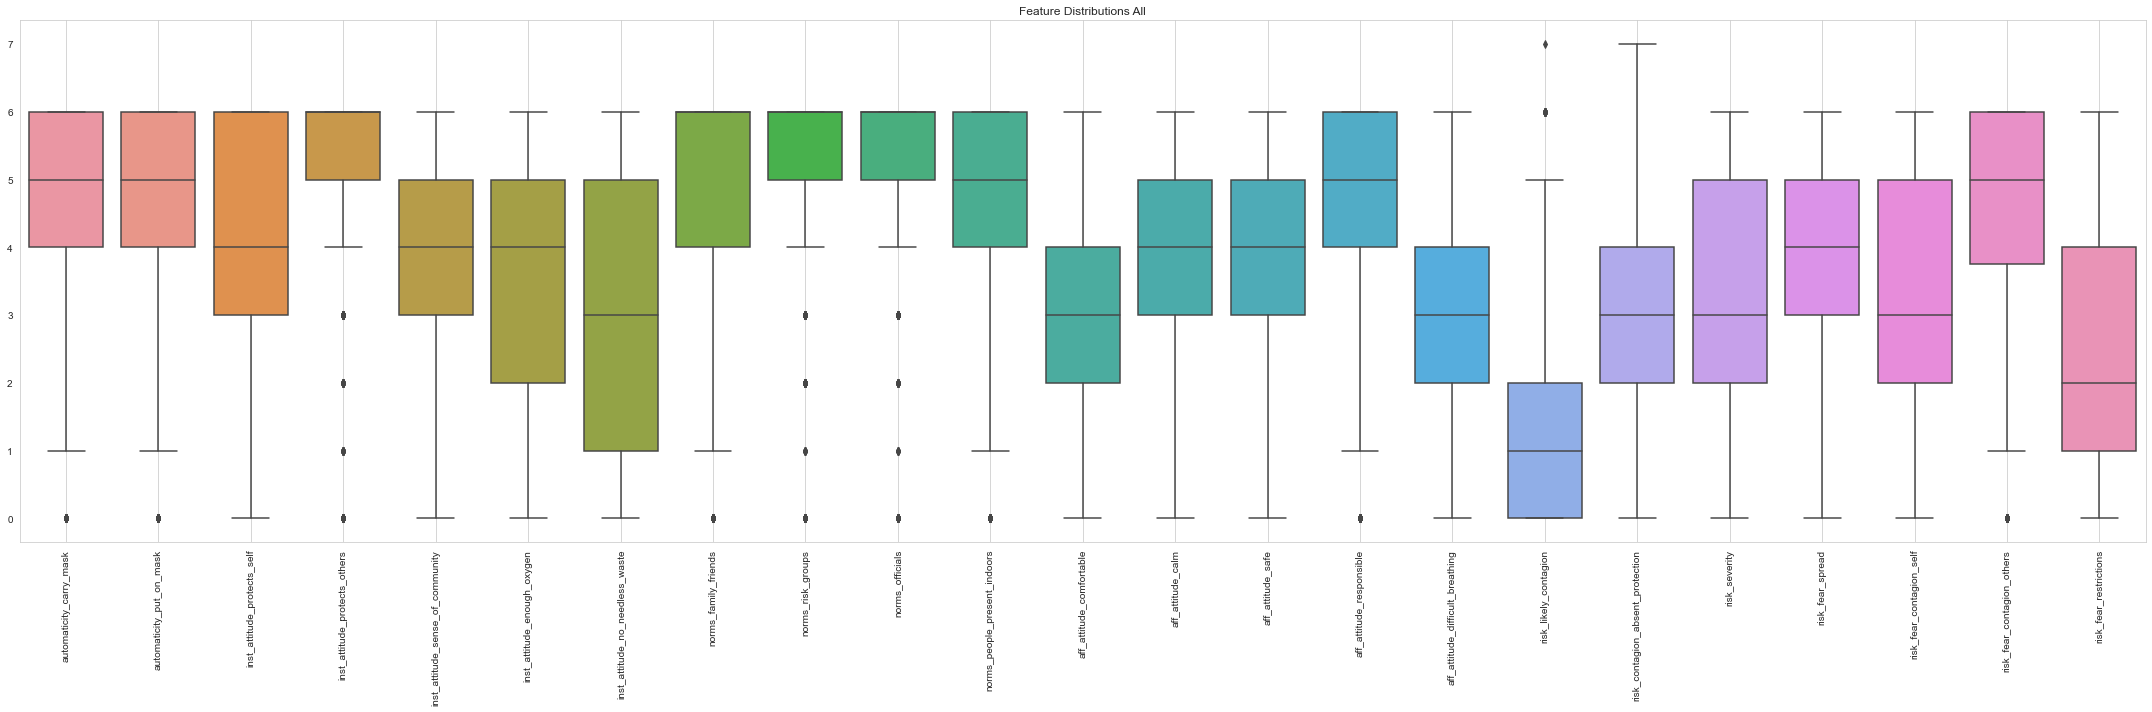

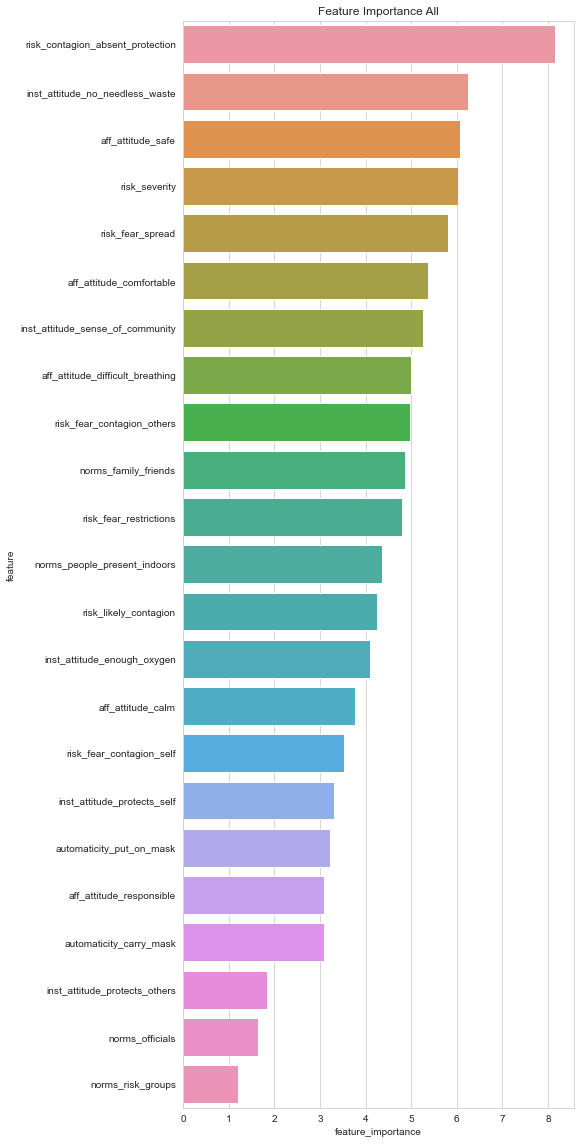

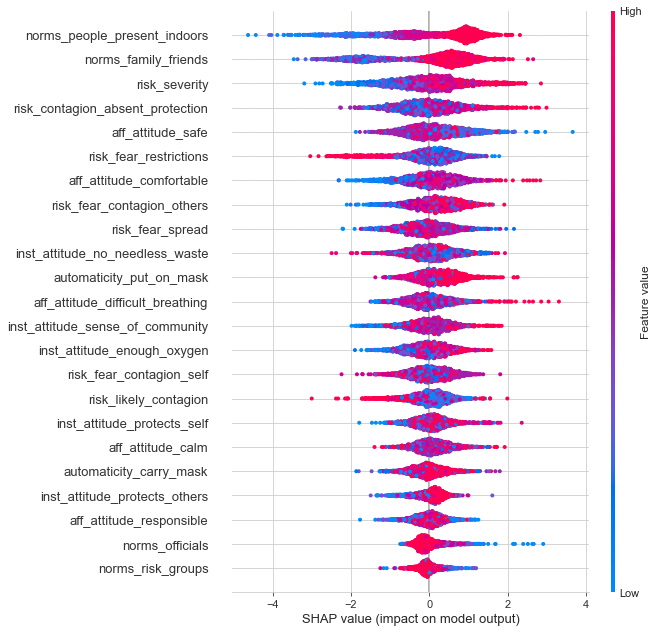

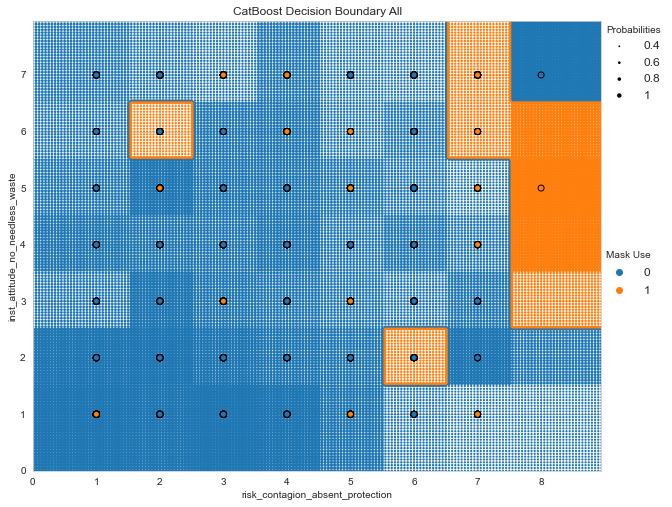

In [30]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[1:],
                                                                                                                                   sample_weights=df.loc[df["demographic_age"].isin(['18-29', '30-39']), "sampling_weight"],
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[1:],
                                                                                                                                   sample_weights=df.loc[df["demographic_age"].isin(['40-49', '50-59']), "sampling_weight"],
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[1:],
                                                                                                                                   sample_weights=df.loc[df["demographic_age"].isin(['60+']), "sampling_weight"],
                                                                                                                                   plot_title="60+"
                                                                                  )

feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[1:],
                                                                                                                                   sample_weights=df.loc[:, "sampling_weight"],
                                                                                                                                   plot_title="All"
                                                                                  )

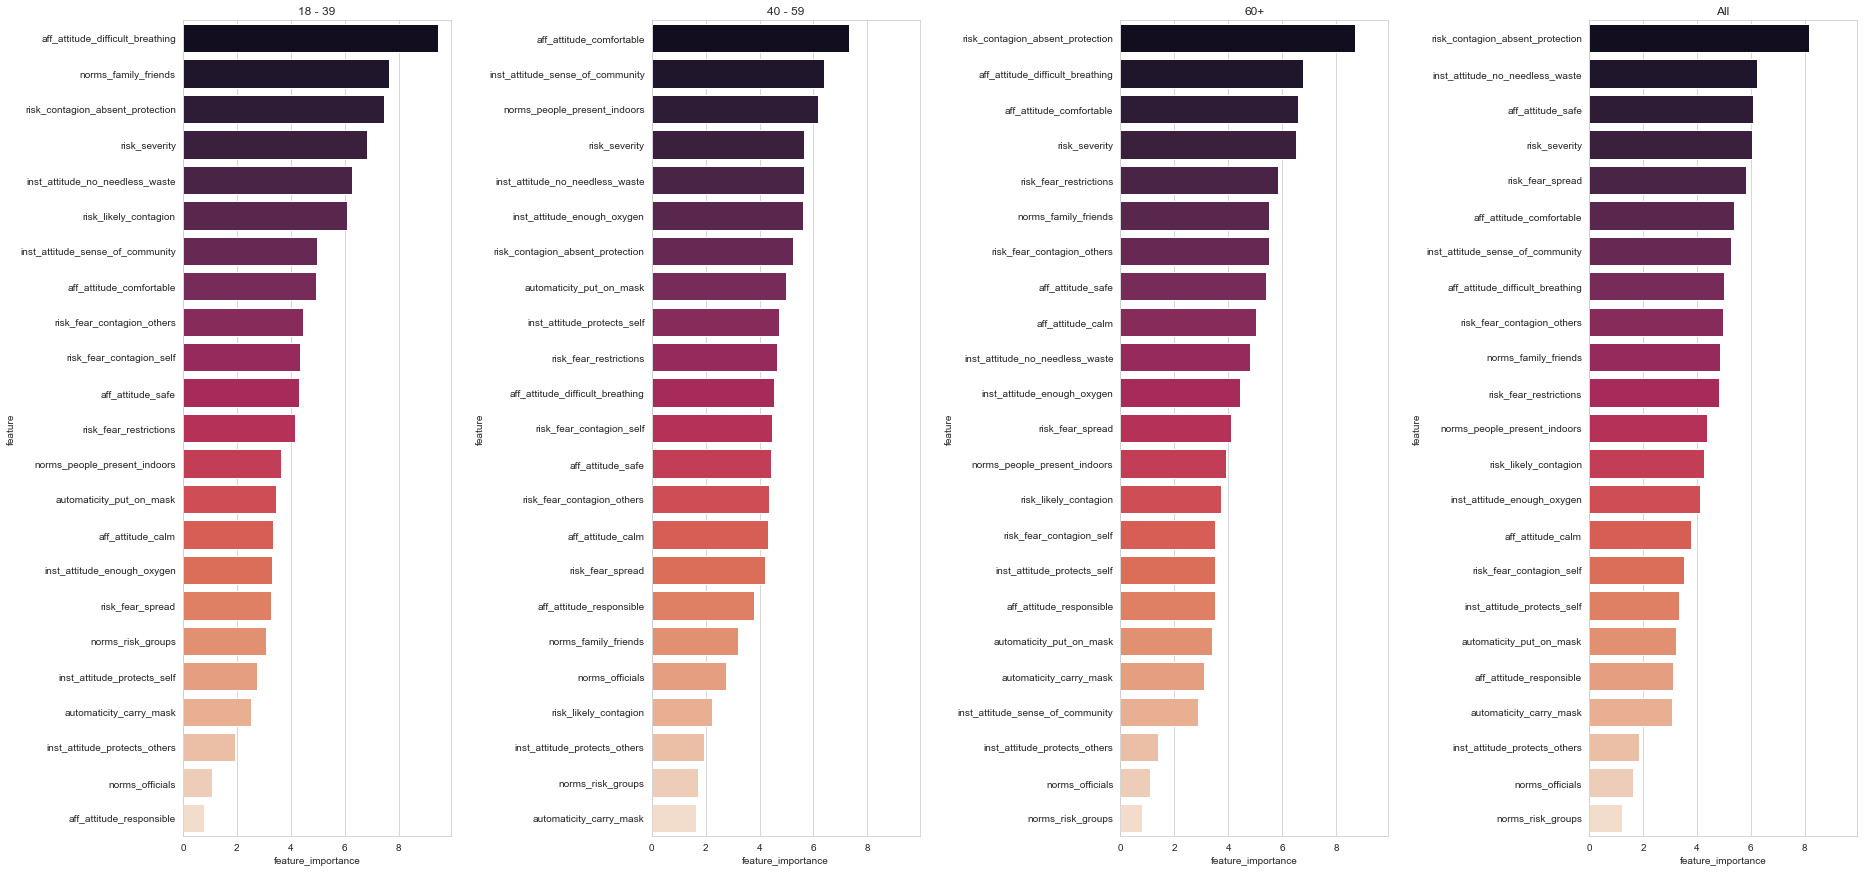

In [31]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [32]:
fig.savefig(f"images/feature_importance_age_groups.png", dpi=400, bbox_inches="tight")

In [33]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

In [34]:
# pd.concat(fi_dfs_list, axis=0).groupby("age_group").head()

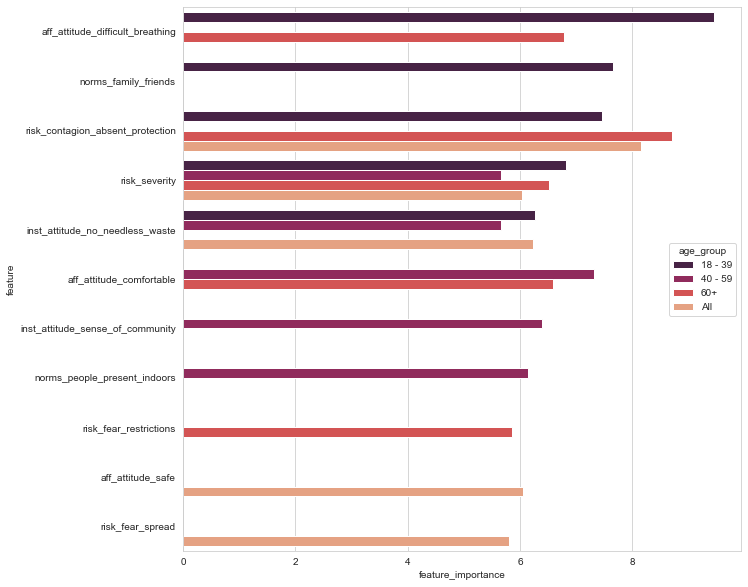

In [35]:
_ = plt.figure(figsize=(10, 10))
_ = sns.barplot(
#     data=pd.concat(fi_dfs_list, axis=0), 
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [36]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [37]:
# fis_df.columns = ['feature_young', 'feature_importance_young', 'feature_middle', 'feature_importance_middle',
#        'feature_old', 'feature_importance_old', 'feature_all', 'feature_importance_all']

In [38]:
fis_df.head(5)

feature  feature_importance age_group  \
0  aff_attitude_difficult_breathing                9.46   18 - 39   
1              norms_family_friends                7.66   18 - 39   
2  risk_contagion_absent_protection                7.46   18 - 39   
3                     risk_severity                6.81   18 - 39   
4   inst_attitude_no_needless_waste                6.27   18 - 39   

                            feature  feature_importance age_group  \
0          aff_attitude_comfortable                7.32   40 - 59   
1  inst_attitude_sense_of_community                6.40   40 - 59   
2      norms_people_present_indoors                6.15   40 - 59   
3                     risk_severity                5.66   40 - 59   
4   inst_attitude_no_needless_waste                5.66   40 - 59   

                            feature  feature_importance age_group  \
0  risk_contagion_absent_protection                8.70       60+   
1  aff_attitude_difficult_breathing                6.79       60+   
2          aff_attitude_comfortable                6.58       60+   
3                     risk_severity                6.52       60+   
4            risk_fear_restrictions                5.85       60+   

                            feature  feature_importance age_group  
0  risk_contagion_absent_protection                8.15       All  
1   inst_attitude_no_needless_waste                6.24       All  
2                 aff_attitude_safe                6.06       All  
3                     risk_severity                6.03       All  
4                  risk_fear_spread                5.81       All

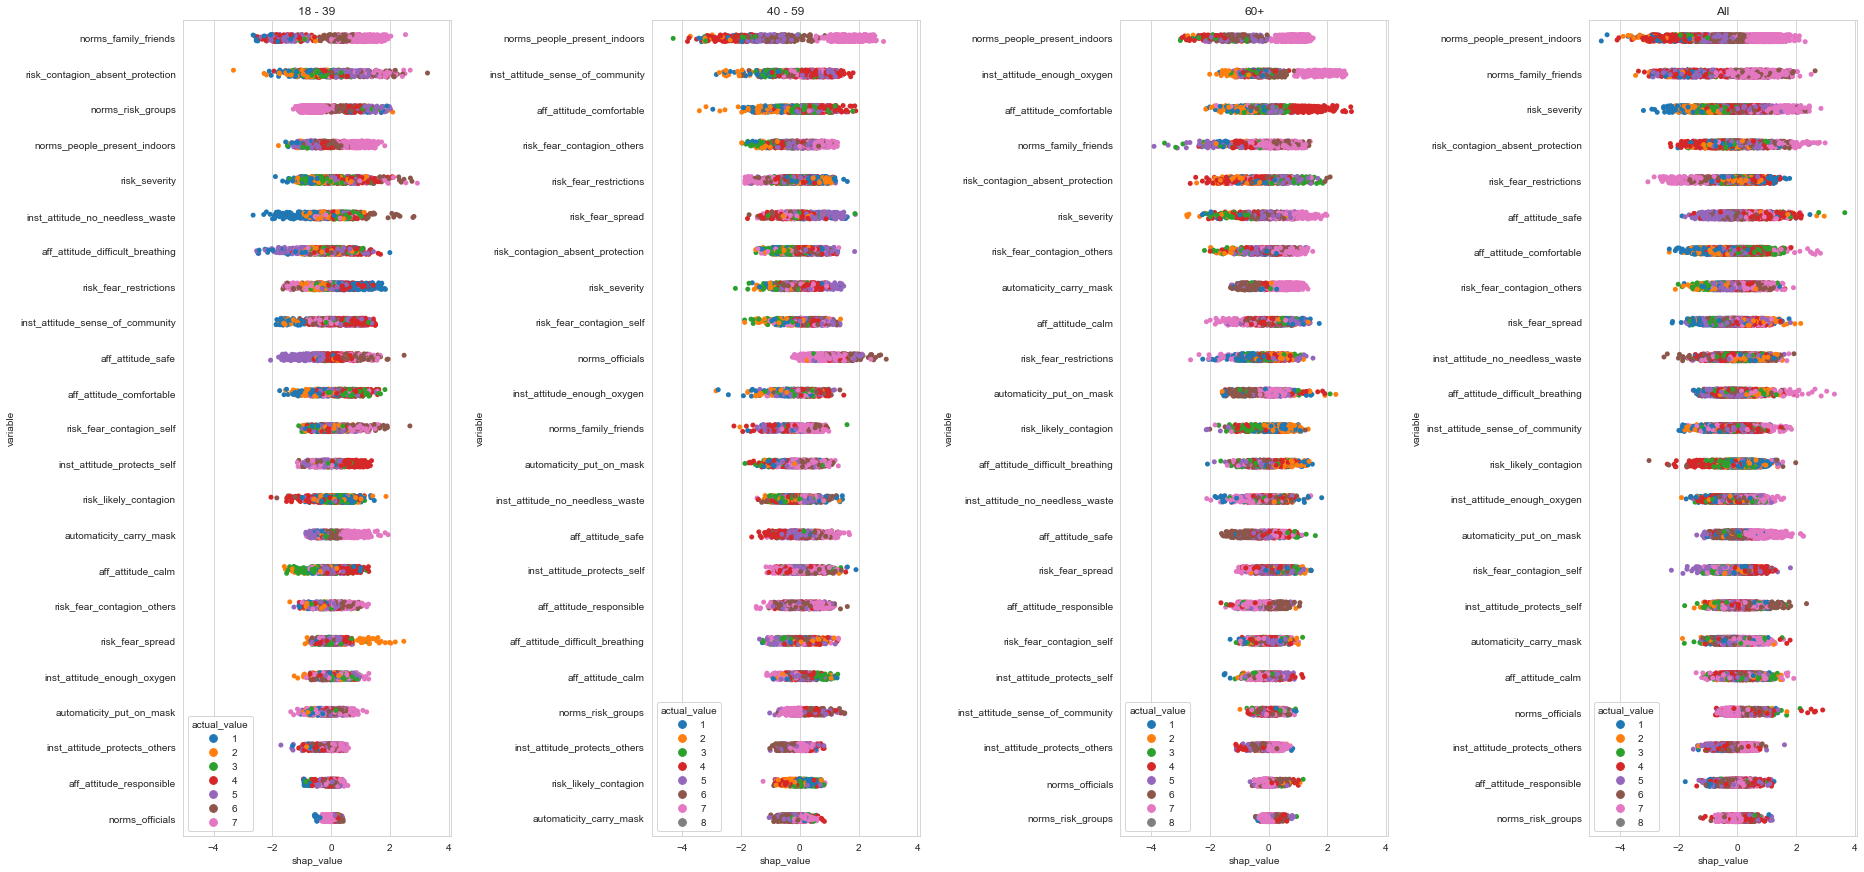

In [39]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
    _ = axs[i].set_title(shap_titles_list[i])
# _ = plt.show()

In [40]:
fig.savefig(f"images/shap_values_all_age_groups.png", dpi=400, bbox_inches="tight")

In [41]:
# shap_plot_3.suptitle("My title")
plot_title = "18 - 39"
shap_plot_0.suptitle(plot_title, y=0.89)
shap_plot_0.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "40 - 59"
shap_plot_1.suptitle(plot_title, y=0.89)
shap_plot_1.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "60+"
shap_plot_2.suptitle(plot_title, y=0.89)
shap_plot_2.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "All"
shap_plot_3.suptitle(plot_title, y=0.89)
shap_plot_3.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")

In [42]:
# dec_bound_plot_0

In [43]:
clf = CatBoostClassifier(iterations=500,
                           depth=None,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)

In [44]:
feature_importance_df_0.head(5).feature.tolist()

['aff_attitude_difficult_breathing',
 'norms_family_friends',
 'risk_contagion_absent_protection',
 'risk_severity',
 'inst_attitude_no_needless_waste']

In [45]:
# tmp_df = df[df["demographic_age"].isin(['18-29', '30-39'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['40-49', '50-59'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['60+'])].reset_index()
tmp_df = df.reset_index()

# X = tmp_df[feature_importance_df_0.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_1.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_2.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_3.head(5).feature.tolist()]

X = tmp_df[features_list[1:]]

# X = tmp_df[df.filter(regex="sdt").columns.tolist()]

y = tmp_df[grouping_var]

sampling_weights = tmp_df["sampling_weight"]

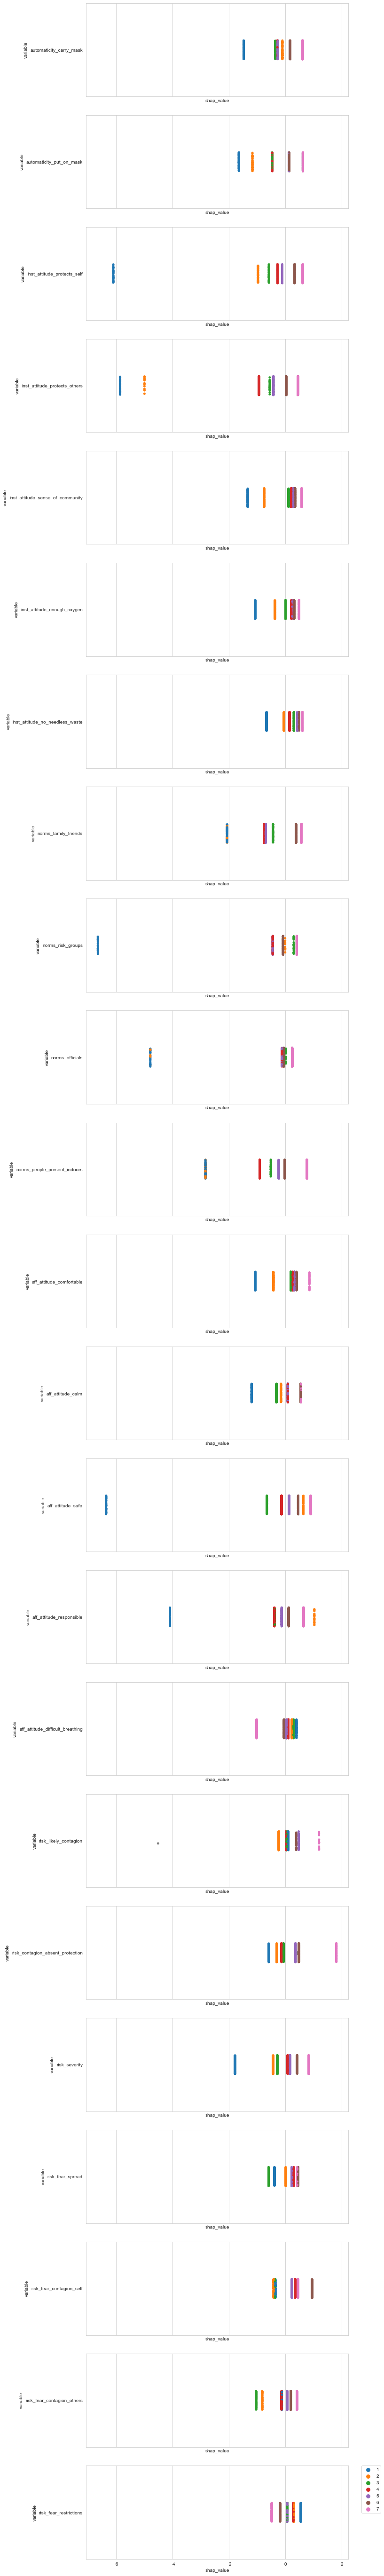

In [46]:
fig, axs = plt.subplots(nrows=X.shape[1],
                 ncols=1,
                 sharex=True,
                 sharey=False,
                       figsize=(10, 100),
#                        gridspec_kw={'wspace': 0.75
#                                    }
                       )

for i in range(0, X.shape[1]):

    feature = X.columns.tolist()[i]
    
    model = CatBoostClassifier(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='Logloss',
                               verbose=False)

    # train the model
    _ = model.fit(X[[feature]], 
                  y, 
                  cat_features=[feature],
                  sample_weight=sampling_weights
                 )

    shap_values = model.get_feature_importance(Pool(X[[feature]], label=y,cat_features=[feature]), type="ShapValues")

    shap_values = shap_values[:,:-1]

    tmp_actual = (X[[feature]]
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=[feature])
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)
    
    if i == X.shape[1]-1:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend_.remove()

In [47]:
_ = fig.savefig(f"images/shap_values_ALL_analysis_seperate_per_feature.png", dpi=400, bbox_inches="tight")

>Train: 0=1234, 1=583, Test: 0=311, 1=144


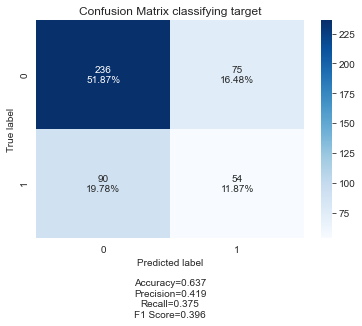

>Train: 0=1240, 1=577, Test: 0=305, 1=150


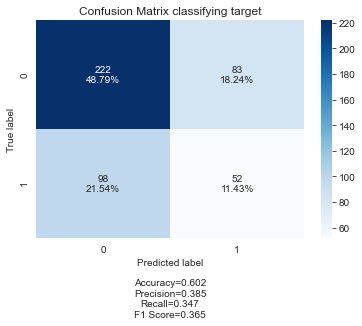

>Train: 0=1239, 1=579, Test: 0=306, 1=148


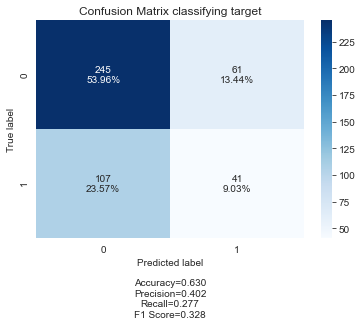

>Train: 0=1230, 1=588, Test: 0=315, 1=139


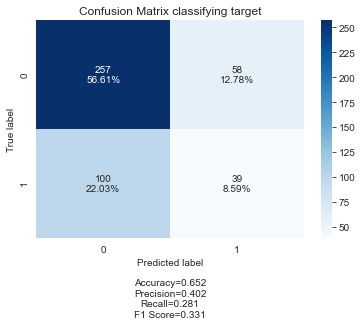

>Train: 0=1237, 1=581, Test: 0=308, 1=146


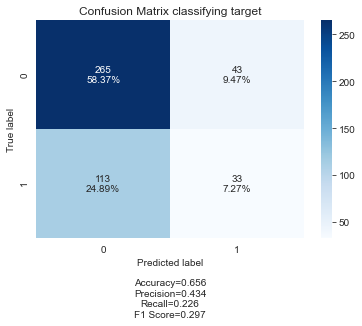

In [48]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    train_weights, test_weights = sampling_weights.loc[train_ix], sampling_weights.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
                cat_features=X.columns,
               sample_weight=train_weights)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()

In [49]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    train_weights, test_weights = sampling_weights.loc[train_ix], sampling_weights.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns,
                sample_weight=train_weights
               )
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

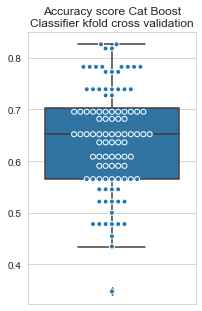

In [50]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Cat Boost\nClassifier kfold cross validation")

In [51]:
pd.DataFrame(accuracies_list).describe().T

count      mean       std       min       25%       50%       75%       max
0  100.0  0.643518  0.100613  0.347826  0.565217  0.652174  0.703557  0.826087

In [52]:
pd.DataFrame(clf.predict_proba(X)).head()

0         1
0  0.030197  0.969803
1  0.593552  0.406448
2  0.761267  0.238733
3  0.676813  0.323187
4  0.916334  0.083666

In [53]:
base_model = CatBoostClassifier(iterations=500,
                           depth=None,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)

In [54]:
model = BalancedBaggingClassifier(base_estimator=base_model, replacement=True)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, 
                         X, 
                         y, 
                         scoring='accuracy', 
                         cv=cv, 
                         n_jobs=-1, 
#                          fit_params={"sample_weight": sampling_weights} # fit_params is returning nans for some reason :/
                        )
# summarize performance
print('Mean accuracy: %.3f' % np.mean(scores))

Mean accuracy: 0.612


In [55]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [56]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [57]:
scoring_list = ('accuracy',
 'balanced_accuracy',
#  'explained_variance',
 'f1',
#  'f1_macro',
#  'f1_micro',
#  'f1_samples',
 'f1_weighted',
#  'neg_log_loss',
#  'neg_root_mean_squared_error',
 'precision',
#  'precision_macro',
#  'precision_micro',
#  'precision_samples',
 'precision_weighted',
 'recall',
#  'recall_macro',
#  'recall_micro',
#  'recall_samples',
 'recall_weighted',
 'roc_auc',
               )

In [58]:
tmp_out = cross_validate(model, 
                         X, 
                         y, 
                         scoring=scoring_list, 
                         return_train_score=False, 
                         cv=cv, 
                         n_jobs=-1,
#                         fit_params={"sample_weight": sampling_weights} # fit_params is returning nans for some reason :/
                        )

In [59]:
pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).agg(["mean", "median", "std"]).round(3)

test_accuracy  test_balanced_accuracy  test_f1  test_f1_weighted  \
mean            0.614                   0.619    0.511             0.626   
median          0.612                   0.619    0.511             0.625   
std             0.031                   0.032    0.036             0.030   

        test_precision  test_precision_weighted  test_recall  \
mean             0.430                    0.667        0.632   
median           0.433                    0.668        0.639   
std              0.031                    0.027        0.058   

        test_recall_weighted  test_roc_auc  
mean                   0.614         0.663  
median                 0.612         0.665  
std                    0.031         0.035

In [60]:
cv_metrics_df = pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).melt(var_name="Metric")

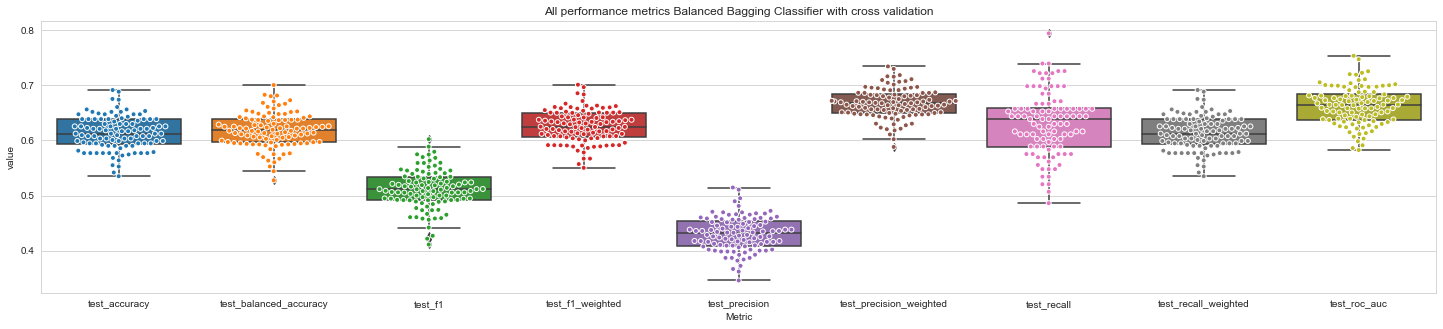

In [61]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = cv_metrics_df,
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = cv_metrics_df,
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title("All performance metrics Balanced Bagging Classifier with cross validation")

In [62]:
pd.DataFrame(scores).describe().T

count      mean       std      min       25%       50%       75%       max
0  100.0  0.612446  0.032395  0.53304  0.590308  0.613185  0.635463  0.674009

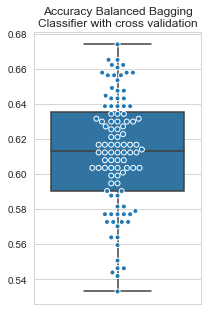

In [63]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = scores)
_ = sns.swarmplot(y = scores, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy Balanced Bagging\nClassifier with cross validation")

In [64]:
class_metrics_df = pd.DataFrame()
kfold = KFold(n_splits=50, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    train_weights, test_weights = sampling_weights.loc[train_ix], sampling_weights.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns,
               sample_weight=train_weights
               )
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))
    
    current_metrics_df = summary_performance_metrics_classification(y_true=test_y, 
                                                                    y_pred=pred_y)
    class_metrics_df = pd.concat([class_metrics_df, current_metrics_df])

In [65]:
# class_metrics_df.melt(var_name="Metric")

In [66]:
metric_cols = ['Accuracy', 'Balanced Accuracy', 'Prevalence', 'Sensitivity',
       'Specificity', 'PPV', 'NPV', 'auc', 'F1']
TF_value = ['TN', 'FP', 'FN', 'TP']

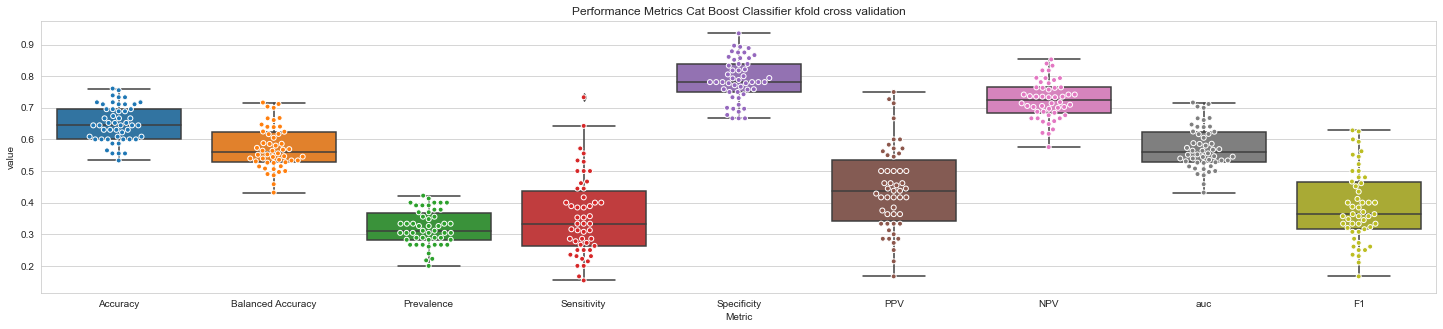

In [67]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = class_metrics_df[metric_cols].melt(var_name="Metric"),
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = class_metrics_df[metric_cols].melt(var_name="Metric"),
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title("Performance Metrics Cat Boost Classifier kfold cross validation")

In [68]:
class_metrics_df[metric_cols].agg(["mean", "median", "std"]).round(3)

Accuracy  Balanced Accuracy  Prevalence  Sensitivity  Specificity  \
mean       0.651              0.573       0.320        0.358        0.788   
median     0.644              0.560       0.311        0.333        0.781   
std        0.058              0.067       0.055        0.126        0.068   

          PPV    NPV    auc     F1  
mean    0.443  0.725  0.573  0.388  
median  0.438  0.726  0.560  0.364  
std     0.132  0.061  0.067  0.114

In [69]:
# _ = plt.figure(figsize=(25,5))
# _ = sns.boxplot(data = class_metrics_df[TF_value].melt(var_name="Metric"),
#                 x = "Metric",
#                 y = "value")
# _ = sns.swarmplot(data = class_metrics_df[TF_value].melt(var_name="Metric"),
#                 x = "Metric",
#                 y = "value", edgecolor="white", linewidth=1)
# _ = plt.title("Performance Metrics Cat Boost Classifier kfold cross validation")

In [70]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# # kfold = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
# # enumerate the splits and summarize the distributions
# for train_ix, test_ix in kfold.split(X):
#     # select rows
#     train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
#     train_y, test_y = y.loc[train_ix], y.loc[test_ix]
#     # summarize train and test composition
#     train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
#     test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
# #     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
#     _ = clf.fit(X = train_X, 
#                 y = train_y,
#                cat_features=X.columns)
    
#     pred_y = clf.predict(test_X)
#     _ = accuracies_list.append(accuracy_score(test_y, pred_y))
    
#     current_metrics_df = summary_performance_metrics_classification(y_true=test_y, 
#                                                                     y_pred=pred_y)
#     class_metrics_df = pd.concat([class_metrics_df, current_metrics_df])